In [1]:
from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import sys, os

greek_cols = [
	'delta',
	'gamma',
	'theta',
	'vega',
	'rho',
	'vanna',
	'vomma',
	'charm',
	'veta',
	'speed',
	'zomma',
	'color',
	'ultima'
]

### Data

In [20]:
df = pd.read_csv("data/data_validation_python.csv")
raw = df.iloc[:, :18]

### More Precise Time

In [21]:
dc = raw.date_current + " 17:00:00"
ed = raw.expiration_date + " 17:00:00"

In [22]:
nraw = raw.copy()
nraw['days_to_expiry'] = (pd.to_datetime(ed) - pd.to_datetime(dc)).dt.days

### Greeks

In [23]:
def calculate_greeks(options):

	if len(options) == 0:
		return options

	o = options.copy()
	m = o.option_type.map({"C" : 1, "P" : -1}).values

	tau = o.days_to_expiry.values / 365
	rtau = np.sqrt(tau)
	iv = o.implied_volatility.values / 100
	S = o.stock_price.values
	K = o.strike_price.values
	q = o.dividend_yield.values / 100
	r = o.rate.values / 100

	###################################################################################################

	eqt = np.exp(-q * tau)
	kert = K * np.exp(-r * tau)

	d1 = np.log(S / K)
	d1 += (r - q + 0.5 * (iv ** 2)) * tau
	d1 /= iv * rtau
	d2 = d1 - iv * rtau

	npd1 = norm.pdf(d1)
	ncd1 = norm.cdf(m * d1)
	ncd2 = norm.cdf(m * d2)

	###################################################################################################

	delta = m * eqt * ncd1

	gamma = np.exp(q - r) * npd1
	gamma /= (S * iv * rtau)

	vega = S * eqt * npd1 * rtau	
	vega /= 100

	rho = m * tau * kert * ncd2
	rho /= 100

	theta = (S * norm.pdf(m * d1) * iv)
	theta *= -eqt / (2 * rtau)
	theta -= m * r * kert * ncd2
	theta += m * q * S * eqt * ncd1
	theta /= 365

	###################################################################################################

	vanna = (vega / S)
	vanna *= (1 - d1 / (iv * rtau))

	vomma = (vega / iv) * (d1 * d2)

	charm = 2 * (r - q) * tau - d2 * iv * rtau
	charm /= 2 * tau * iv * rtau
	charm *= eqt * npd1
	charm = m * q * eqt * ncd1 - charm
	charm /= 365

	veta = q.copy()
	veta += ((r - q) * d1) / (iv * rtau)
	veta -= (1 + d1 * d2) / (2 * tau)
	veta *= -S * eqt * npd1 * rtau
	veta /= 365 * 100

	speed = 1
	speed += d1 / (iv * rtau)
	speed *= -gamma / S

	zomma = (d1 * d2 - 1) / iv
	zomma *= gamma

	color = 2 * (r - q) * tau
	color -= d2 * iv * rtau
	color *= d1 / (iv * rtau)
	color += 2 * q * tau + 1
	color *= -eqt * npd1 / (2 * S * tau * iv * rtau)
	color /= 365

	ultima = d1 * d2 * (1 - d1 * d2) + d1 * d1 + d2 * d2
	ultima *= -vega / (iv * iv)

	###################################################################################################

	options['delta'] = delta
	options['gamma'] = gamma
	options['theta'] = theta
	options['vega'] = vega
	options['rho'] = rho

	options['vanna'] = vanna
	options['vomma'] = vomma
	options['charm'] = charm
	options['veta'] = veta
	options['speed'] = speed
	options['zomma'] = zomma
	options['color'] = color
	options['ultima'] = ultima

	###################################################################################################

	options.loc[:, greek_cols] = options[greek_cols].replace([-np.inf, np.inf], np.nan)
	options.loc[:, greek_cols] = options[greek_cols].round(6).fillna(0)
	options = options.sort_values(["date_current", "option_type"], ascending=True)

	return options

In [24]:
raw = calculate_greeks(raw)
nraw = calculate_greeks(nraw)

### Comparison

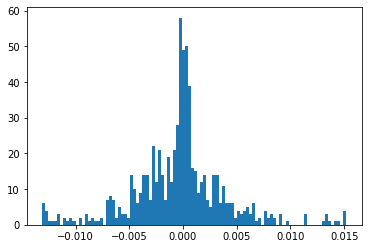

In [27]:
greek = 'delta'
tmp = pd.DataFrame()
tmp['New'] = nraw[greek]
tmp['Old'] = raw[greek]
plt.hist(tmp.New - tmp.Old, bins=100)
plt.show()

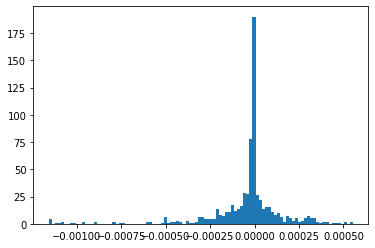

In [28]:
greek = 'gamma'
tmp = pd.DataFrame()
tmp['New'] = nraw[greek]
tmp['Old'] = raw[greek]
plt.hist(tmp.New - tmp.Old, bins=100)
plt.show()

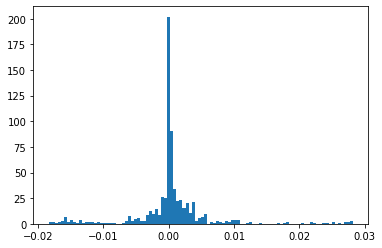

In [29]:
greek = 'theta'
tmp = pd.DataFrame()
tmp['New'] = nraw[greek]
tmp['Old'] = raw[greek]
plt.hist(tmp.New - tmp.Old, bins=100)
plt.show()

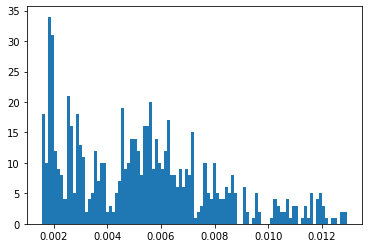

In [30]:
greek = 'vega'
tmp = pd.DataFrame()
tmp['New'] = nraw[greek]
tmp['Old'] = raw[greek]
plt.hist(tmp.New - tmp.Old, bins=100)
plt.show()

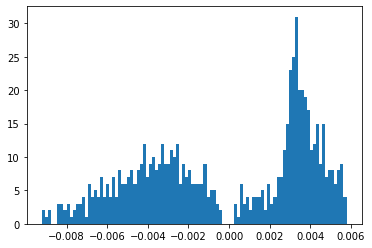

In [31]:
greek = 'rho'
tmp = pd.DataFrame()
tmp['New'] = nraw[greek]
tmp['Old'] = raw[greek]
plt.hist(tmp.New - tmp.Old, bins=100)
plt.show()

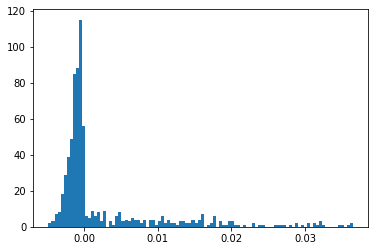

In [32]:
greek = 'vomma'
tmp = pd.DataFrame()
tmp['New'] = nraw[greek]
tmp['Old'] = raw[greek]
plt.hist(tmp.New - tmp.Old, bins=100)
plt.show()

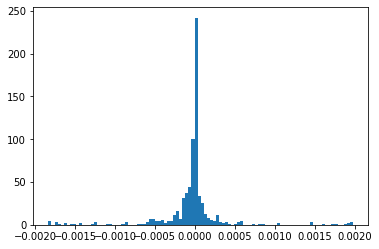

In [33]:
greek = 'charm'
tmp = pd.DataFrame()
tmp['New'] = nraw[greek]
tmp['Old'] = raw[greek]
plt.hist(tmp.New - tmp.Old, bins=100)
plt.show()

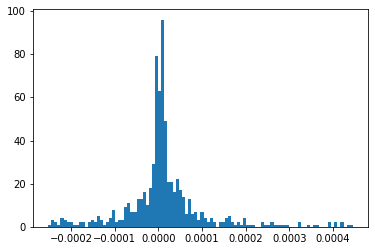

In [34]:
greek = 'vanna'
tmp = pd.DataFrame()
tmp['New'] = nraw[greek]
tmp['Old'] = raw[greek]
plt.hist(tmp.New - tmp.Old, bins=100)
plt.show()

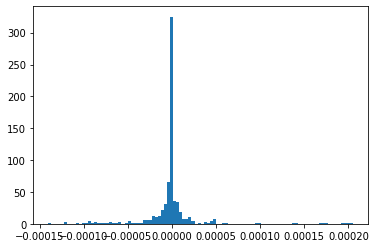

In [35]:
greek = 'color'
tmp = pd.DataFrame()
tmp['New'] = nraw[greek]
tmp['Old'] = raw[greek]
plt.hist(tmp.New - tmp.Old, bins=100)
plt.show()

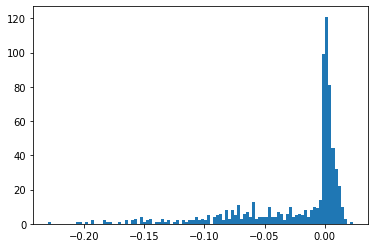

In [36]:
greek = 'ultima'
tmp = pd.DataFrame()
tmp['New'] = nraw[greek]
tmp['Old'] = raw[greek]
plt.hist(tmp.New - tmp.Old, bins=100)
plt.show()

### Check BBG

In [37]:
df.columns

Index(['date_current', 'ticker', 'expiration_date', 'days_to_expiry',
       'option_id', 'option_type', 'strike_price', 'bid_price', 'option_price',
       'mid_price', 'ask_price', 'implied_volatility', 'volume',
       'open_interest', 'stock_price', 'dividend_yield', 'rate', 'delta',
       'gamma', 'theta', 'vega', 'rho', 'vanna', 'vomma', 'charm', 'veta',
       'speed', 'zomma', 'color', 'ultima', 'mnyness', 'last', 'bid', 'mid',
       'ask', 'implied vol using last trade price',
       'volume, if no volume traded field will display most recent volume on whatever day it last traded',
       'DELTA_MID', 'GAMMA_LAST', 'THETA_LAST', 'VEGA_LAST', 'RHO_LAST',
       'Stock Price'],
      dtype='object')

In [53]:
bbg = df.DELTA_MID.str.replace("%", "").astype(float) / 100
yh1 = raw.delta
yh2 = nraw.delta

In [54]:
((bbg - yh1) ** 2).sum() ** 0.5

0.24795666265700544

In [55]:
((bbg - yh2) ** 2).sum() ** 0.5

0.2880396368193101

In [62]:
bbg = df.VEGA_LAST
yh1 = raw.vega
yh2 = nraw.vega

In [63]:
((bbg - yh1) ** 2).sum() ** 0.5

0.22157174025358015

In [64]:
((bbg - yh2) ** 2).sum() ** 0.5

0.23586901055034765

In [65]:
bbg = df.THETA_LAST
yh1 = raw.vega
yh2 = nraw.vega

In [66]:
((bbg - yh1) ** 2).sum() ** 0.5

13.825587530410887

In [67]:
((bbg - yh2) ** 2).sum() ** 0.5

13.929026293520053